# Naive Bayes, SVM e Random Forest usando vetores produzidos pelo TFIDF

## importações e carregamento do conjunto de dados

In [8]:
import pandas as pd
import numpy as np
from scipy.sparse import load_npz

from sklearn import naive_bayes
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

import optuna

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

In [2]:
X_train = load_npz('../vectors/tfidf_lemma/X_train_tfidf.npz')
y_train = np.load('../vectors/tfidf_lemma/y_train.npy')

X_test = load_npz('../vectors/tfidf_lemma/X_test_tfidf.npz')
y_test = np.load('../vectors/tfidf_lemma/y_test.npy')

In [3]:
class_weights = dict(zip(range(len(np.unique(y_train))), 1 / np.bincount(y_train)))
labels = ['0','1','2','3']

## Naive Bayes

### Validação cruzada padrão

In [18]:
from sklearn import naive_bayes

NB_std = naive_bayes.MultinomialNB()

scores = cross_val_score(NB_std, X_train, y_train, cv=10)

print(scores)
scores.mean()

[0.44359756 0.47256098 0.4222561  0.44207317 0.44359756 0.43597561
 0.42835366 0.44817073 0.4527439  0.46189024]


0.4451219512195122

### Encontrando melhores hiperparâmetros

In [11]:
def NB_opt(trial):
    params = {
        
    }

    model = naive_bayes.MultinomialNB(**params)

    score = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5).mean()

    return score

In [12]:
study = optuna.create_study(direction='maximize')  # Estamos maximizando a acurácia
study.optimize(NB_opt, n_trials=50)

[I 2023-12-16 12:24:56,572] A new study created in memory with name: no-name-8b52d045-edb7-4ddc-a7e2-e072518388e8
[I 2023-12-16 12:24:56,598] Trial 0 finished with value: 0.4411585365853658 and parameters: {}. Best is trial 0 with value: 0.4411585365853658.
[I 2023-12-16 12:24:56,621] Trial 1 finished with value: 0.4411585365853658 and parameters: {}. Best is trial 0 with value: 0.4411585365853658.
[I 2023-12-16 12:24:56,641] Trial 2 finished with value: 0.4411585365853658 and parameters: {}. Best is trial 0 with value: 0.4411585365853658.
[I 2023-12-16 12:24:56,668] Trial 3 finished with value: 0.4411585365853658 and parameters: {}. Best is trial 0 with value: 0.4411585365853658.
[I 2023-12-16 12:24:56,696] Trial 4 finished with value: 0.4411585365853658 and parameters: {}. Best is trial 0 with value: 0.4411585365853658.
[I 2023-12-16 12:24:56,718] Trial 5 finished with value: 0.4411585365853658 and parameters: {}. Best is trial 0 with value: 0.4411585365853658.
[I 2023-12-16 12:24:56

### Treinando com os melhores hiperparâmetros

In [19]:
NB_bst = naive_bayes.MultinomialNB()
NB_bst.fit(X_train, y_train)

NB_y_pred = NB_bst.predict(X_test)

accuracy_score(y_test, NB_y_pred)

0.4530487804878049

### Resultados

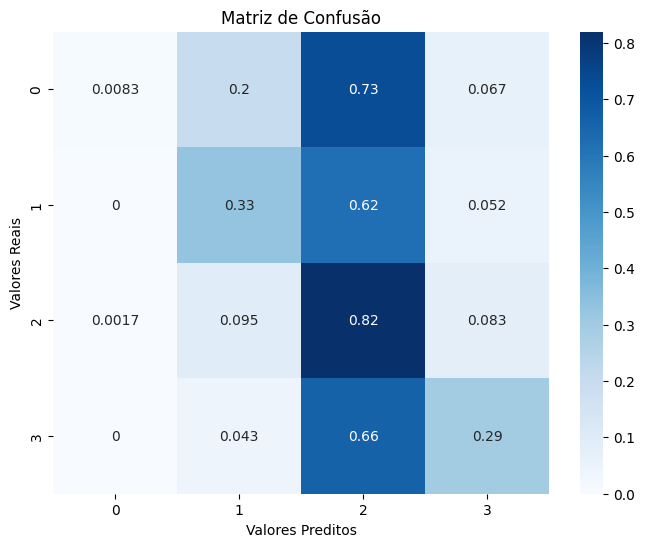

In [20]:
cm_NB = confusion_matrix(y_test, NB_y_pred)

cm_NB = cm_NB.astype('float') / cm_NB.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_NB, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

## SVM

### Validação cruzada padrão

In [4]:
from sklearn.svm import SVC

SVM_std = SVC()

scores = cross_val_score(SVM_std, X_train, y_train, cv=10)

print(scores)
scores.mean()

[0.51981707 0.51676829 0.48932927 0.49847561 0.50304878 0.50304878
 0.49390244 0.51829268 0.52896341 0.49695122]


0.5068597560975611

### Encontrando melhores hiperparâmetros

In [12]:
def SVM_opt(trial):
    # Defina os hiperparâmetros que você deseja otimizar
    C = trial.suggest_float('C', 1, 1e5, log=True)
    
    # Construa o modelo SVM
    model = SVC(C=C, kernel='linear', class_weight='balanced')

    score = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5).mean()

    return score

In [ ]:
study = optuna.create_study(direction='maximize')  # Estamos maximizando a acurácia
study.optimize(SVM_opt, n_trials=25)

### Treinando com os melhores hiperparâmetros

In [14]:
SVM_bst = SVC(class_weight='balanced', probability=True)
SVM_bst.fit(X_train, y_train)

SVM_y_pred = SVM_bst.predict(X_test)

accuracy_score(y_test, SVM_y_pred)

0.5042682926829268

In [15]:
from sklearn.metrics import classification_report

report = classification_report(y_test, SVM_y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.41      0.37      0.39       240
           1       0.49      0.49      0.49       400
           2       0.52      0.46      0.49       600
           3       0.55      0.67      0.60       400

    accuracy                           0.50      1640
   macro avg       0.49      0.50      0.49      1640
weighted avg       0.50      0.50      0.50      1640



### Resultados

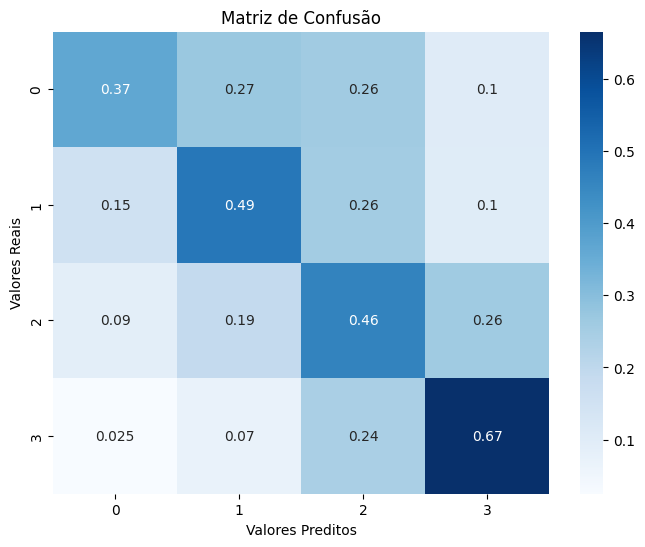

In [21]:
cm_SVM = confusion_matrix(y_test, SVM_y_pred)

cm_SVM = cm_SVM.astype('float') / cm_SVM.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_SVM, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

## Random Forest

### Validação cruzada padrão

In [7]:
from sklearn.ensemble import RandomForestClassifier

RF_std = RandomForestClassifier()

RF_scores = cross_val_score(RF_std, X_train, y_train, cv=10)

print(RF_scores)
RF_scores.mean()

[0.52439024 0.51371951 0.51676829 0.50609756 0.49847561 0.51981707
 0.50914634 0.51829268 0.49695122 0.49695122]


0.5100609756097562

### Encontrando melhores hiperparâmetros

In [25]:
def RF_opt(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 50, 200),
        'class_weight': class_weights,
    }

    model = RandomForestClassifier(**params)

    score = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5).mean()

    return score

In [26]:
study = optuna.create_study(direction='maximize')  # Estamos maximizando a acurácia
study.optimize(RF_opt, n_trials=50)

[I 2023-12-16 12:42:00,889] A new study created in memory with name: no-name-5256eb4f-30e2-445d-ba51-7ce78a11fdee
[I 2023-12-16 12:44:03,840] Trial 0 finished with value: 0.5117378048780488 and parameters: {'n_estimators': 184, 'max_depth': 131}. Best is trial 0 with value: 0.5117378048780488.
[I 2023-12-16 12:44:52,173] Trial 1 finished with value: 0.5076219512195121 and parameters: {'n_estimators': 91, 'max_depth': 62}. Best is trial 0 with value: 0.5117378048780488.
[I 2023-12-16 12:46:02,039] Trial 2 finished with value: 0.5071646341463414 and parameters: {'n_estimators': 105, 'max_depth': 167}. Best is trial 0 with value: 0.5117378048780488.
[I 2023-12-16 12:47:29,119] Trial 3 finished with value: 0.5164634146341462 and parameters: {'n_estimators': 130, 'max_depth': 178}. Best is trial 3 with value: 0.5164634146341462.
[I 2023-12-16 12:48:50,167] Trial 4 finished with value: 0.5079268292682927 and parameters: {'n_estimators': 119, 'max_depth': 103}. Best is trial 3 with value: 0.5

### Treinando com os melhores hiperparâmetros

In [22]:
RF_bst = RandomForestClassifier(n_estimators=167, max_depth=176, class_weight=class_weights)
RF_bst.fit(X_train, y_train)

RF_y_pred = RF_bst.predict(X_test)

accuracy_score(y_test, RF_y_pred)

0.5054878048780488

### Resultados

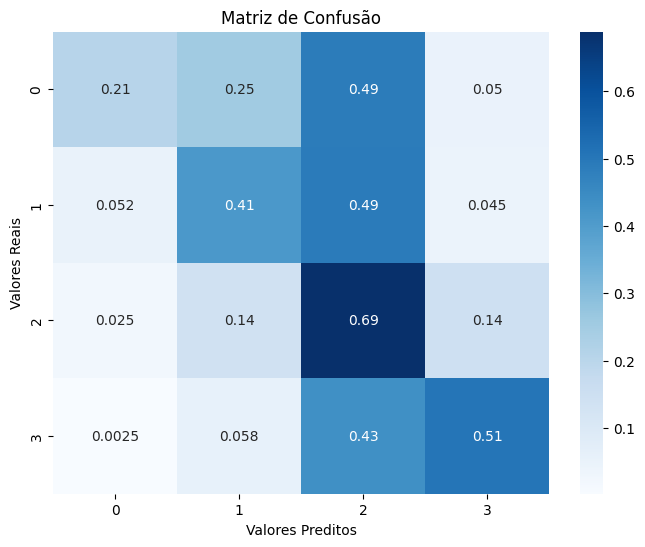

In [23]:
cm_RF = confusion_matrix(y_test, RF_y_pred)

cm_RF = cm_RF.astype('float') / cm_RF.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_RF, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

## Comparando os três modelos

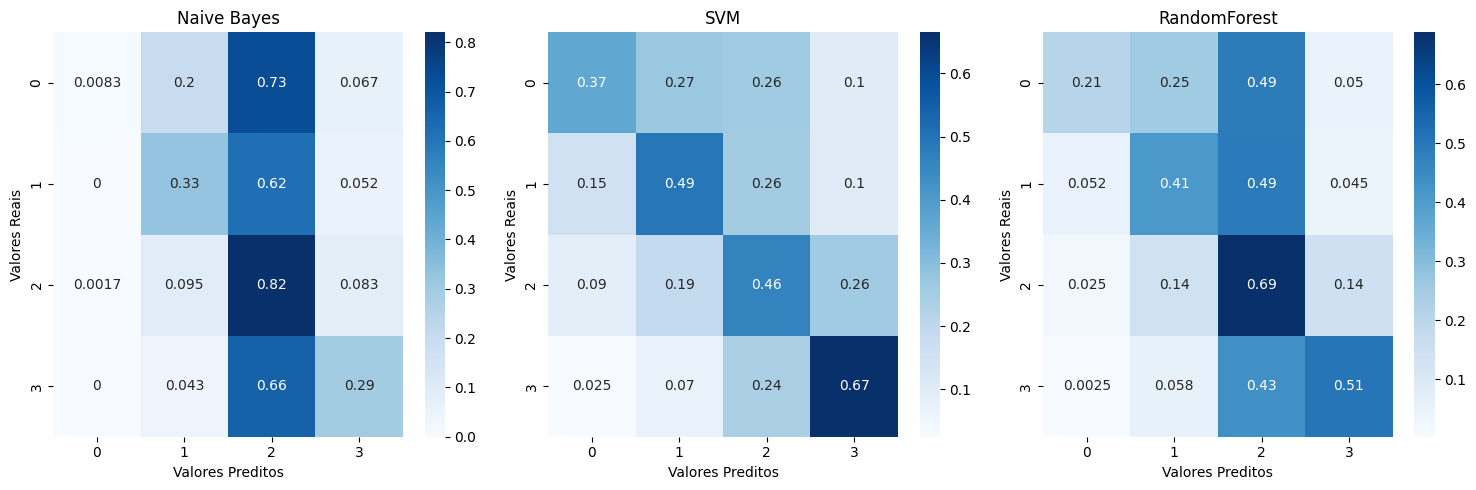

In [24]:
# Configurar subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plotar cada matriz de confusão em um subplot
for i, (cm, model_name) in enumerate(zip([cm_NB, cm_SVM, cm_RF], ['Naive Bayes', 'SVM', 'RandomForest'])):
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels, ax=axes[i])
    axes[i].set_title(f'{model_name}')
    axes[i].set_xlabel('Valores Preditos')
    axes[i].set_ylabel('Valores Reais')

plt.tight_layout()
plt.show()

## Armazenando modelos treinados

In [63]:
with open('../models_dump/NB_CV43_T43.pkl', 'wb') as file:
    pickle.dump(NB_bst, file)

with open('../models_dump/SVM_CV50_T50.pkl', 'wb') as file:
    pickle.dump(SVM_bst, file)

with open('../models_dump/RF_CV51_T51.pkl', 'wb') as file:
    pickle.dump(RF_bst, file)